# Talking Shop: Do higher temperatures increase icecream sales?

## Import Libraries
First, import some libraries used throughout the rest of this notebook.

In [1]:
# import data analysis library
import pandas
# import numpy
import numpy
# import visualization library; plotting module
import matplotlib.pyplot as pyplot
# import visualization library;
import seaborn
# import a database toolkit library; query engine module
from sqlalchemy.engine import create_engine
# import scipy science toolkit; pearsonR correlation module
from scipy.stats.stats import pearsonr
# import Ipython display library; html display module
from IPython.display import display_html

## Create data connection
Next, establish a connection to autodaas data platform

In [2]:
# create a presto engine using the sqlalchemy create_engine 
engine = create_engine('presto://localhost:8080/hive')

### List and preview the datasets
Then, we review our datasets before beginning the analysis.
- create variables for reference throughout the notebook for each dataset
- convert the data tables into dataframes by querying each dataset using SQL.
- preview each dataset to look at the columns and data in each dataset.

#### place into variables and convert queries into dataframes

In [3]:
# place dataset names into variables
monthlyavgtemps = 'adviews.monthlyavgtemp'
icecreamsales_wfm = 'adviews.icecreamdb_productsales_wholefoods_icecream'
icecreamsales_star = 'adviews.icecreamdb_productsales_starmarket_icecream'
icecreamsales_stop = 'adviews.icecreamdb_productsales_stopandshop_icecream'

# query each dataset into a dataframe (python table structure) using pandas read_sql function
df_monthlyavgtemps = pandas.read_sql(
"""
    select * from %s
""" % (monthlyavgtemps)
, engine)
# -----------------------------------------------
df_icecreamsales_wfm = pandas.read_sql(
"""
    select * from %s ORDER BY sales_date ASC
""" % (icecreamsales_wfm)
, engine)
# -----------------------------------------------
df_icecreamsales_star = pandas.read_sql(
"""
    select * from %s ORDER BY sales_date ASC
""" % (icecreamsales_star)
, engine)
# -----------------------------------------------
df_icecreamsales_stop = pandas.read_sql(
"""
    select * from %s ORDER BY sales_date ASC
""" % (icecreamsales_stop)
, engine)

#### display dataset previews

In [4]:
# display dataframe previews inline
df1 = df_monthlyavgtemps.head(3) \
    .style.set_table_attributes("style='display:inline'").set_caption(monthlyavgtemps)
df2 = df_icecreamsales_wfm.head(3) \
    .style.set_table_attributes("style='display:inline'").set_caption(icecreamsales_wfm)
df3 = df_icecreamsales_star.head(3) \
    .style.set_table_attributes("style='display:inline'").set_caption(icecreamsales_star)
df4 = df_icecreamsales_stop.head(3) \
    .style.set_table_attributes("style='display:inline'").set_caption(icecreamsales_stop)
display_html(
    df1._repr_html_()\
    +df2._repr_html_()\
    +df3._repr_html_()\
    +df4._repr_html_(), raw=True)

adviews.monthlyavgtemp 
 
 
 measure_year 
 measure_month 
 avgtemp 
 
 
 0 
 2015 
 1 
 36 
 
 1 
 2015 
 2 
 39 
 
 2 
 2015 
 3 
 45 
 
 
 adviews.icecreamdb_productsales_wholefoods_icecream 
 
 
 sales_date 
 customer_id 
 brand 
 flavor 
 units 
 location_address 
 
 
 0 
 2015-01-02 00:00:00.000 
 8306 
 Ben & Jerrys 
 Karamel Sutra Core 
 1 
 181 Cambridge St, Boston, MA 02114 
 
 1 
 2015-01-02 00:00:00.000 
 8194 
 Talenti 
 Peanut Butter Pretzel 
 1 
 181 Cambridge St, Boston, MA 02114 
 
 2 
 2015-01-03 00:00:00.000 
 8810 
 Talenti 
 Coffee Chocolate Chip Gelato 
 1 
 181 Cambridge St, Boston, MA 02114 
 
 
 adviews.icecreamdb_productsales_starmarket_icecream 
 
 
 sales_date 
 customer_id 
 brand 
 flavor 
 units 
 location_address 
 
 
 0 
 2015-01-01 00:00:00.000 
 926 
 Magnum 
 Double Chocolate Vanilla 
 1 
 53 Huntington Ave, Boston, MA 02199 
 
 1 
 2015-01-01 00:00:00.000 
 8899 
 Magnum 
 Double Cherry Truffle 
 1 
 53 Huntington Ave, Boston, MA 02199 
 
 2 
 2015-01-01 00:00:00.000 
 4519 
 Magnum 
 Double Cookies & Cream 
 2 
 53 Huntington Ave, Boston, MA 02199 
 
 
 adviews.icecreamdb_productsales_stopandshop_icecream 
 
 
 sales_date 
 customer_id 
 brand 
 flavor 
 units 
 location_address 
 
 
 0 
 2015-01-01 00:00:00.000 
 2808 
 Ben & Jerrys 
 Chubby Hubby 
 3 
 713 E Broadway, Boston, MA 02127 
 
 1 
 2015-01-02 00:00:00.000 
 6471 
 Magnum 
 Double Caramel 
 1 
 713 E Broadway, Boston, MA 02127 
 
 2 
 2015-01-02 00:00:00.000 
 1714 
 Ben & Jerrys 
 Frozen Flakes 
 1 
 713 E Broadway, Boston, MA 02127

### Utilize SQL to transform data
- utilize sql to create a master dataframe
    - union all product sales tables
    - join temperatures and the above union query
    - average aggregation of temperatures (by year, month)
    - sum aggregation of units sold (by month)

#### create sql query using variables

In [5]:
# generate a sql query using table name variables
master_df_sql = """
select 
	sales_month,
	avg(avgtemp) as avgtemp,
	sum(units) as units
from 
	(
		select
			YEAR(sales_date) as sales_year,
			MONTH(sales_date) as sales_month,
			avgtemp,
			units
		from 
		(
			  select
				sales_date,
				units
			  from
				%s
			union
			  select
				sales_date,
				units
			  from
				%s
			union
			 select
				sales_date,
				units
			  from
				%s
		)
		join
			%s
			on
				measure_year =  YEAR(sales_date)
				and
				measure_month = MONTH(sales_date)
		order by YEAR(sales_date), MONTH(sales_date) asc
	)
group by sales_month
order by sales_month asc
""" % (icecreamsales_wfm, icecreamsales_star, icecreamsales_stop, monthlyavgtemps)

## print sql for debugging
# print master_df_sql

In [6]:
# master dataframe sql query
print master_df_sql


select 
	sales_month,
	avg(avgtemp) as avgtemp,
	sum(units) as units
from 
	(
		select
			YEAR(sales_date) as sales_year,
			MONTH(sales_date) as sales_month,
			avgtemp,
			units
		from 
		(
			  select
				sales_date,
				units
			  from
				adviews.icecreamdb_productsales_wholefoods_icecream
			union
			  select
				sales_date,
				units
			  from
				adviews.icecreamdb_productsales_starmarket_icecream
			union
			 select
				sales_date,
				units
			  from
				adviews.icecreamdb_productsales_stopandshop_icecream
		)
		join
			adviews.monthlyavgtemp
			on
				measure_year =  YEAR(sales_date)
				and
				measure_month = MONTH(sales_date)
		order by YEAR(sales_date), MONTH(sales_date) asc
	)
group by sales_month
order by sales_month asc



#### convert sql query into master dataframe

In [7]:
# run sql query into a dataframe
df_master = pandas.read_sql(master_df_sql , engine)
df_master

,sales_month,avgtemp,units
0,1,35.775100,523
1,2,38.602510,505
2,3,44.615702,541
3,4,55.724000,523
4,5,65.618881,626
5,6,75.604096,643
6,7,80.656160,857
7,8,79.640127,722
8,9,71.604982,753
9,10,58.010204,427


## Describe and Analyze dataset
Finally, we use statistical and visualization tools to support hypothesis

### Use statistical tools for a data overivew

#### statistical description of dataset
- description: show count, mean, standard deviation quartiles and min/max of dataset
- insight: various statistics such as average monthly unit sales, standard deviation of sales per month and maximum unit sales can be found below.

In [8]:
# generate statistical description of the dataset
df_master.describe()

,sales_month,avgtemp,units
count,12.000000,12.000000,12.000000
mean,6.500000,58.177250,606.500000
std,3.605551,16.320090,121.272421
min,1.000000,35.775100,427.000000
25%,3.750000,43.631777,523.000000
50%,6.500000,56.867102,579.000000
75%,9.250000,72.604761,662.750000
max,12.000000,80.656160,857.000000


#### correlation value between avg temperature and units sold
- description: pearson R correlation between average temperature and units sold.
- insight
    - 77% correlation shows there is a strong positive correlation between average temperature and units sold.
    - 0.003 value for p shows that it is statistically significant

In [9]:
# find correlation between average temperatures and units sold
avgtemp = df_master['avgtemp']
salesunits = df_master['units']

# run and print pearsonR correlation analysis
pearsonr_coefficient, p_value = pearsonr(avgtemp, salesunits)
pearsonr(avgtemp, salesunits)

(0.7524213683950883, 0.004749848851924717)

### Use visualization tools for a data overview

#### scatter graph matrix of each attribute
- description: a matrix plot of each variable against every other variable in the dataset
- insight: insight is shown in close-up for each meaningful graphs below.

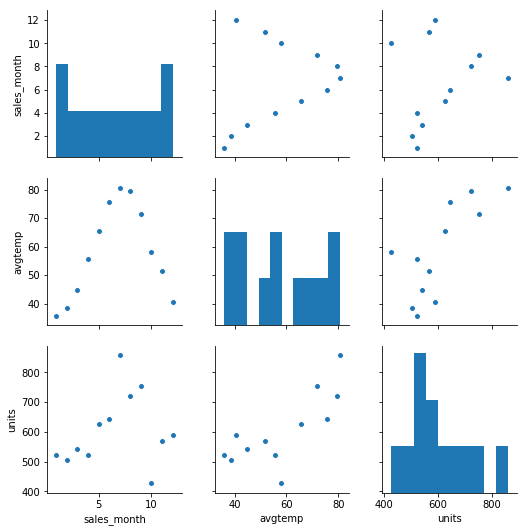

In [10]:
# plot a matrix of visualizations of the dataset
seaborn.pairplot(df_master)

#### average temperature vs sales month
- description: average temperature plotted over sales months.
- insight: average temperature is highest in the mid-year months.

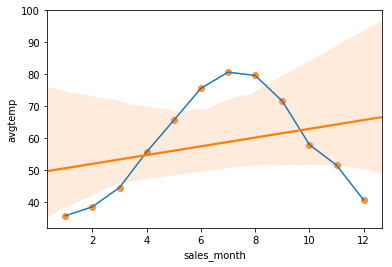

In [11]:
 # add one to index since months are 1-12, not 0-11
df_master['avgtemp'].index +=1
# line plot of average temperatures
df_master['avgtemp'].plot()
# scatter plot of average temperature by sales month, with regression line fit
seaborn.regplot(df_master['sales_month'], df_master['avgtemp'])

#### units vs sales month
- description: units sold by each sales month.
- insight: units sold are highest in the mid-year months.

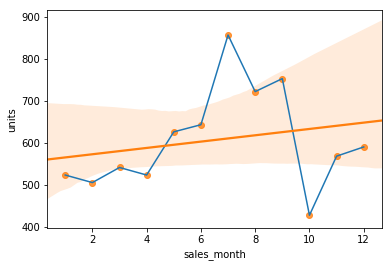

In [12]:
 # add one to index since months are 1-12, not 0-11
df_master['units'].index +=1
# line plot of units sold
df_master['units'].plot()
# scatter plot of units sold by sales month, with regression line fit
seaborn.regplot(df_master['sales_month'], df_master['units'])

#### average temperature vs units sold
- description: scatter plot with a linear regression line and model fit of units sold by average temperature.
- insight: as average temperature increases the units sold increases.

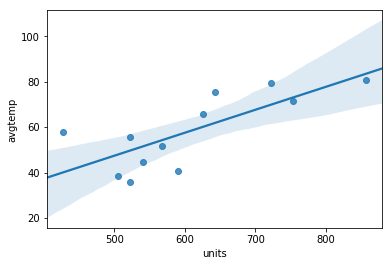

In [13]:
# scatter plot of units sold by average temperature, with regression line fit
seaborn.regplot(df_master['units'], df_master['avgtemp'])

## Conclusion

### Do higher temperatures increase icecream sales?
Based on our analysis using correlation and visualization; We can conclude it is likely that higher temperatures increase ice cream sales. Seemingly, we should increase the production and distribution of our ice cream brands to retailers during the higher temperature months.

A word of caution, correlation does not mean causation, however we did review the data from multiple angles and it looks good. We can increase the size of the data set over time (more years) to strengthen our conclusion.